In [25]:
from IPython.display import Markdown,display

display(Markdown("header.md"))

<h3 align="center">Group 24</h3>
<h5 align="center">7 December 2023</h5>


|Name|Student Number |
|:---|:---|
|Sean Harboe Bateman|200203025|
|Martin Stokholm Lauridsen|201908195|
|Christain Duwe Konnerup|202010016|

# O4 Spotify streams prediction 


### Description of problem and dataset

We aim to create a model predicting the number of streams a song is likely to receive using a dataset that includes artist information, release details, and audio features. Our goal is to explore how these features influence a song’s popularity and build a regression model for stream prediction.
We want to see if it is possible to se how popular a song will be. If possible, could this be beneficial for the music industry? If you know what will be a hit you could target your marketing strategies, you could optimize automatic playlist creations and therby enhance user experiences and more.
We have chosen a dataset of the most streamed songs in 2023. The list doesn’t only contain songs that are released in the year 2023. The list also contains songs that have been released going back to the 1960’s and thereby provides us with a little broader variety of songs.
“This dataset contains a comprehensive list of the most famous songs of 2023 as listed on Spotify. The dataset offers a wealth of features beyond what is typically available in similar datasets. It provides insights into each song’s attributes, popularity, and presence on various music platforms. The dataset includes information such as track name, artist(s) name, release date, Spotify playlists and charts, streaming statistics, Apple Music presence, Deezer presence, Shazam charts, and various audio features.”
Description of the dataset and the dataset it self was found kaggle.
Source: https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023


### List of features

__Basic Information:__

- track_name: Name of the song
- artist(s)_name: Name of the artist(s) of the song
- artist_count: Number of artists contributing to the song

__Release Information:__

- released_year: Year when the song was released
- released_month: Month when the song was released
- released_day: Day of the month when the song was released

__Platform Presence:__

- in_spotify_playlists: Number of Spotify playlists the song is included in
- in_spotify_charts: Presence and rank of the song on Spotify charts
- in_apple_playlists: Number of Apple Music playlists the song is included in
- in_apple_charts: Presence and rank of the song on Apple Music charts
- in_deezer_playlists: Number of Deezer playlists the song is included in
- in_deezer_charts: Presence and rank of the song on Deezer charts
- in_shazam_charts: Presence and rank of the song on Shazam charts

__Streaming Statistics:__

- streams: Total number of streams on Spotify

__Audio Features:__

- bpm: Beats per minute, a measure of song tempo
- key: Key of the song
- mode: Mode of the song (major or minor)
- danceability_%: Percentage indicating how suitable the song is for dancing
- valence_%: Positivity of the song's musical content
- energy_%: Perceived energy level of the song
- acousticness_%: Amount of acoustic sound in the song
- instrumentalness_%: Amount of instrumental content in the song
- liveness_%: Presence of live performance elements
- speechiness_%: Amount of spoken words in the song

The list above is all the features within the dataset. There are 953 samples. The dataset provides us with an attribute *streams*, which represents the total amount of times a song has been streamed. This attribute will be used as ground-truth for our model as we will assume that most streams equals to most popular.


We know that there are some factors that we can't take or will not be taken into account and therefor can't be measured.
It's difficult to say wether if a song has been used on a score in a movie, in advertisment, a meme or some other reason for a song to be streamed more.
Furthermore we don't know anything about the listeners demographic which might also could give some insight in wether how much a song would be streamed.
There is properbly other things that could influence the number of streams aswell, but we will only be looking at the data within the dataset.

Depending on which values are missing we will decide on what to do. A small peak into the data revealed that only two columns were missing values. The two columns were *in_shazam_chart* which had 50 missing values and *key* missing 95 values. Depending on what values are missing an appropriate value is chosen. It kind of depens on what influence it might have on the model. We have to look and compare the values in there if forinstance there is a coherence between the *key* and how many *streams*. If not we might just remove the column. The same goes for the *in_shazam_chart*. But if there is a kind of coherens we might have to fill out the values in the columns. But it's only in about 5% and 10% of the cases.

We plan regression analysis using the dataset to predict stream counts. Exploring relationships between features, we aim to develop a model offering insights for targeted music industry strategies, playlist curation, and enhanced user experiences, addressing missing values for model robustness.


### Importing libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Show all columns.
pd.set_option('display.max_columns', None)  

# This will ensure that the DataFrame doesn't wrap around when displayed.
pd.set_option('display.expand_frame_repr', False)  

# Loading data set
spotify_dataset = pd.read_csv('./spotify-2023.csv', encoding='ISO-8859-1')

### Data exploration

In [3]:
# Shape
print('dataframe shape: ', spotify_dataset.shape)

# Overview of the data types of in each column
print('\ncolumn data types:\n',spotify_dataset.dtypes)

dataframe shape:  (953, 24)

column data types:
 track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object


We see that not all feature coloumn have numerical values, so the following features has to be converted to numerical values:
- streams
- key
- mode
- in_deezer_playlists
- in_shazam_charts


In [4]:
# check for missing values and print the features with null values
nullvalues = spotify_dataset.isnull().sum()
nullvalues = nullvalues[nullvalues > 0]
print('\nMissing values in each column:\n', nullvalues)


Missing values in each column:
 in_shazam_charts    50
key                 95
dtype: int64


### Data cleaning

We have chosen to combine the features for release year, month and day into one called release_date. This is to simplify the data. Furthermore, we one-hot encode the mode column to make it easier to work with. For the in shazam charts we chose to fil in empty values with the max value + 1. For the keys that are null it indicates no keys was found, so we replace the null values with -1 
source = https://developer.spotify.com/documentation/web-api/reference/get-audio-features

#### Combining the released -year, -month, and -day

In [5]:
# Combining the released -year, -month, and -day
spotify_dataset['released_date'] = pd.to_datetime(spotify_dataset['released_year'].astype(str) + '-' +
                        spotify_dataset['released_month'].astype(str) + '-' +
                        spotify_dataset['released_day'].astype(str), errors='coerce')

# We remove the original year, month, and day columns
spotify_dataset.drop(['released_year', 'released_month', 'released_day'], axis=1, inplace=True)

spotify_dataset['released_date'] = (spotify_dataset['released_date'] - spotify_dataset['released_date'].min()).dt.days

#### One-hot encoding the mode column

In [6]:
# One-hot encode the 'mode' column
mode_dummies = pd.get_dummies(spotify_dataset['mode'], prefix='mode')

# Concatenate the new columns with the original DataFrame
spotify_dataset = pd.concat([spotify_dataset, mode_dummies], axis=1)

# removing the original column
spotify_dataset.drop('mode', axis=1, inplace=True)

#### Replacing NaN values

In [7]:
# Convert in_shazam_charts into float
spotify_dataset['in_shazam_charts'] = spotify_dataset['in_shazam_charts'].replace(',','',regex=True).astype(float)

maximum = spotify_dataset['in_shazam_charts'].max()
# Replace NaN
spotify_dataset['in_shazam_charts'].fillna(maximum+1, inplace=True)

In [8]:
# Replace NaN in key with -1
spotify_dataset['key'] = spotify_dataset['key'].fillna(-1)

In [9]:
# Replace invalid data for streams to null 
spotify_dataset['streams'] = pd.to_numeric(spotify_dataset['streams'], errors='coerce')

#### Making keys numeric

In [10]:
# transfer keys into numeric datatype
key_num = {
    'C':0,
    'C#':1,
    'D':2,
    'D#':3,
    'E':4,
    'F':5,
    'F#':6,
    'G':7,
    'G#':8,
    'A':9,
    'A#':10,
    'B':11
}

spotify_dataset['key'] = spotify_dataset['key'].map(key_num).fillna(-1)

#### Transform of deezer and shazam charts columns

In [11]:
spotify_dataset['in_deezer_playlists'] = spotify_dataset['in_deezer_playlists'].replace(',', '', regex=True).astype('int64')
spotify_dataset['in_shazam_charts'] = spotify_dataset['in_shazam_charts'].replace(',', '', regex=True).astype('int64')

In [12]:
# Drop the null value in the 'streams' column
spotify_dataset = spotify_dataset.dropna(how='any')

Now we no longer have null values in the dataset. Perfect now time to fix remaing types.

#### Fixing the remaining types

In [13]:
import warnings
# first we make a copy of the dataset to ensure we are not working on the view
spotify_dataset_copy = spotify_dataset.copy()

warnings.filterwarnings("ignore", category=DeprecationWarning) 
spotify_dataset_copy.loc[:, 'key'] = spotify_dataset_copy['key'].astype('int64')
spotify_dataset_copy.loc[:, 'streams'] = spotify_dataset_copy['streams'].astype('int64')

In [14]:
# Check and remove duplicate rows
duplicates = spotify_dataset_copy.duplicated()
spotify_dataset_copy = spotify_dataset_copy[~duplicates]

In [15]:
# Remove artist names and track name columns since they are not numerical
spotify_dataset_copy = spotify_dataset_copy.drop(['artist(s)_name','track_name'], axis=1)

### Data visualization

#### Distribution of streams

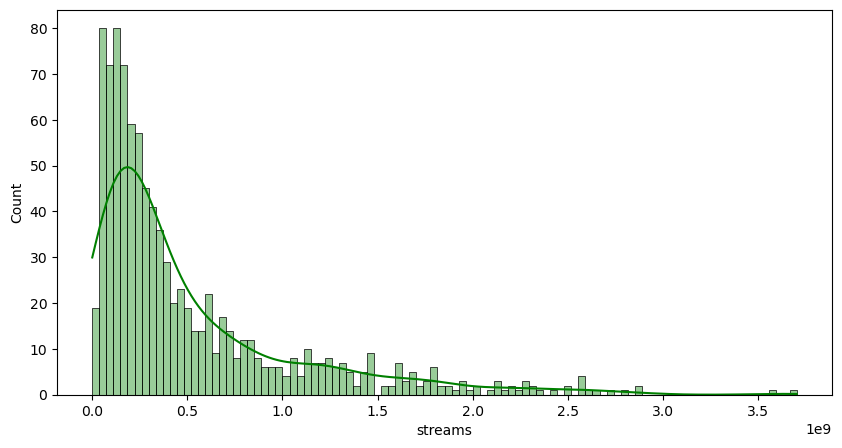

In [16]:
# Provides the summary of streams
plt.figure(figsize=(10, 5)) 
sns.histplot(data=spotify_dataset_copy['streams'], color='g',bins=100, alpha=0.4, kde=True)
plt.show()

It is fairly skewed to the left, which means that most songs have a low number of streams. This is expected since most songs are not popular.

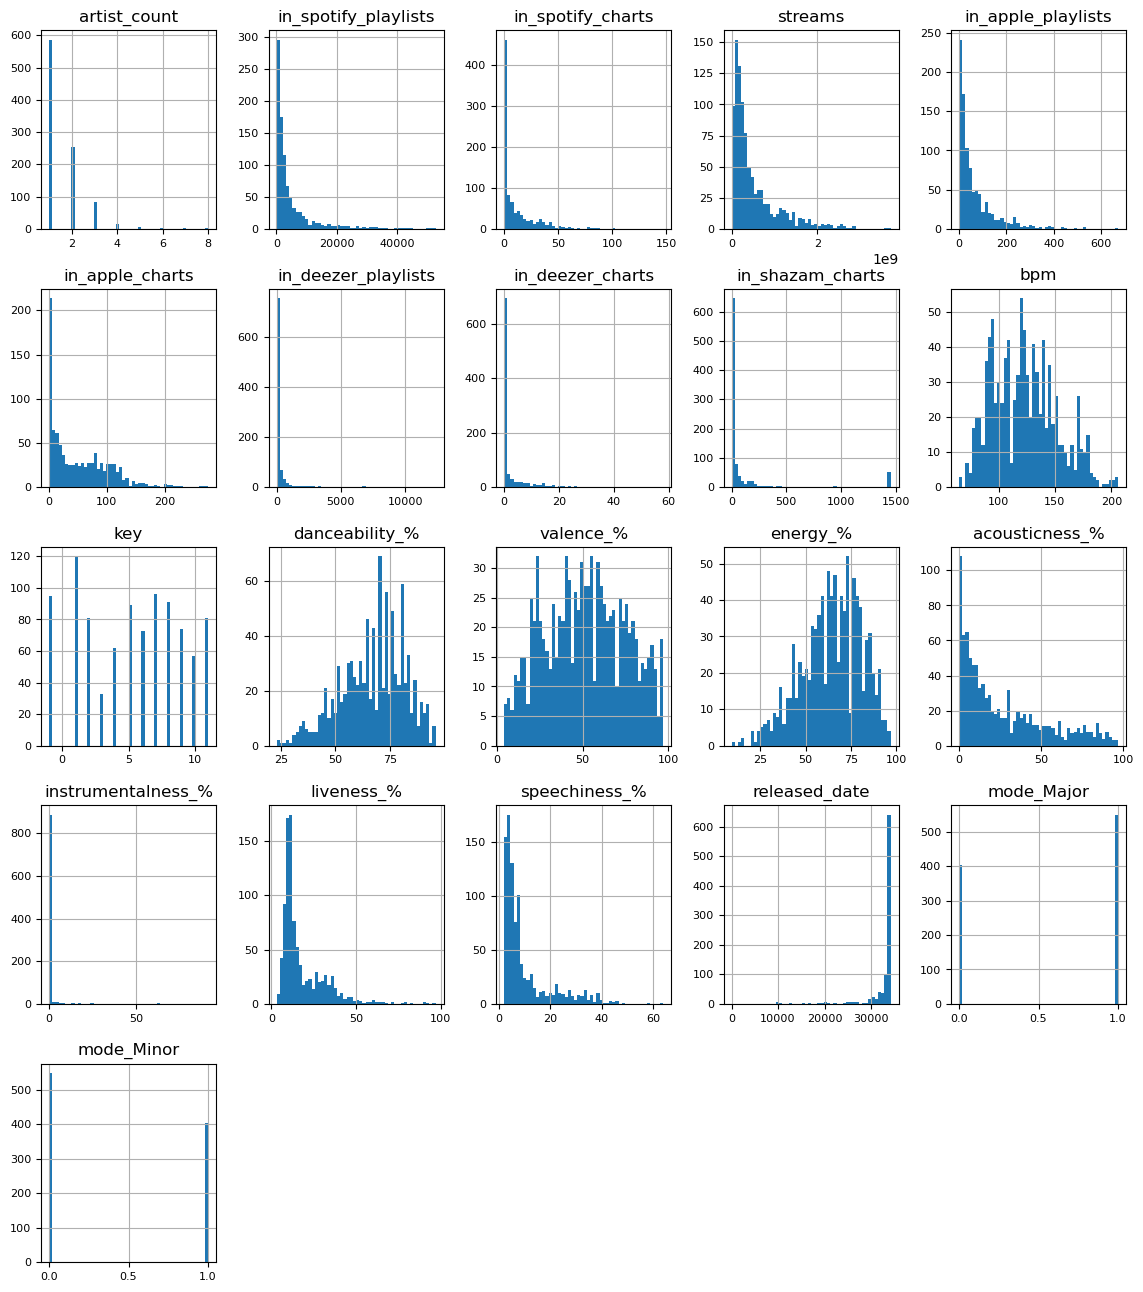

In [17]:
spotify_dataset_copy.hist(figsize=(14, 16), bins=50, xlabelsize=8, ylabelsize=8);


From the histograms we observe that the plots for "in-x-playlist" are skewed to 
the left side which means most songs are in few playlists while a few 
songs are in many playlists. 
Basically popular songs are in many playlists, while unpopular songs are in few
 playlists. The same thing is true for the "in-x-charts" plots.

As with the release day, year and month that we combined to reduce dimensions, we can do the same with the in-x-playlist and in-x-charts. We can combine each of the playlist coloumns into one "total_playlist". This will further reduce the dimensions and make it easier to work with.

In [18]:
spotify_dataset_copy['total_playlist'] = spotify_dataset_copy['in_spotify_playlists'] + \
                       spotify_dataset_copy['in_apple_playlists'] + \
                       spotify_dataset_copy['in_deezer_playlists']

spotify_dataset_copy.drop(['in_spotify_playlists','in_apple_playlists','in_deezer_playlists'], axis=1, inplace=True)

And the same for the charts combined into one total_charts

In [19]:
spotify_dataset_copy['total_charts'] = spotify_dataset_copy['in_spotify_charts'] + \
                 spotify_dataset_copy['in_apple_charts'] + \
                 spotify_dataset_copy['in_deezer_charts'] + \
                 spotify_dataset_copy['in_shazam_charts']

spotify_dataset_copy.drop(['in_spotify_charts','in_apple_charts','in_deezer_charts','in_shazam_charts'], axis=1, inplace=True)

#### Correlation matrix

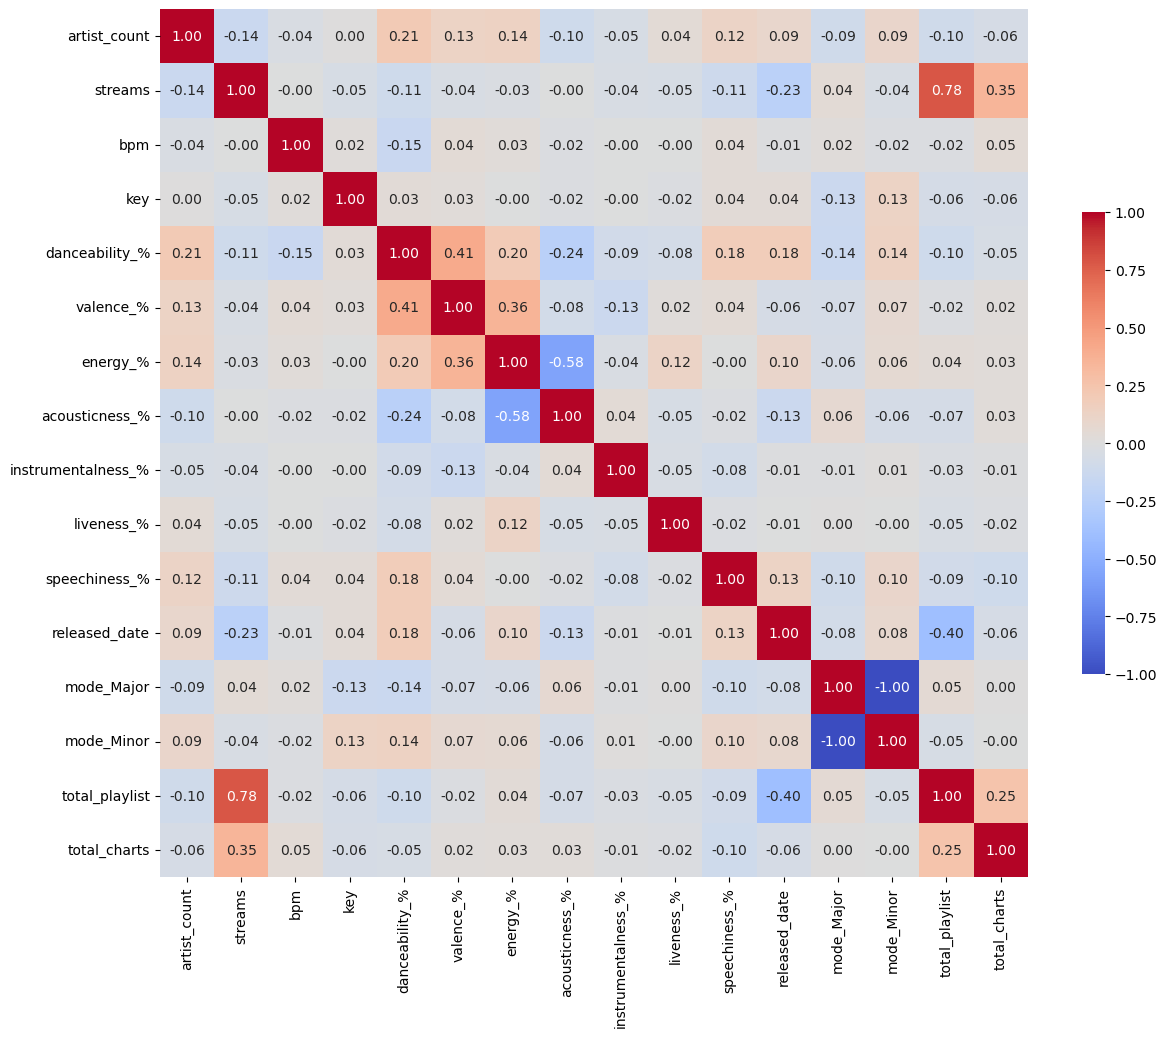

In [20]:
correlation_matrix = spotify_dataset_copy.corr()

plt.figure(figsize=(14, 12))

# Heatmap 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

# Show the plot
plt.show()

From the correlation matrix we gather that there is a strong correlation between the total_playlist and streams of 0.78 and aswell as correlation of 0.35 between total_charts and streams. For the rest of the features not much are correlating with streams.

### Making the model 

After the data exploration and visualization we are ready to make the model. Seing as the dataset has many features that might have some multicollinearity we try the Random forrest regressor among other more complex algorithm. This is because they are less sensitive to multicollinearity compared to a simple linear regressor. Especially the GradientBoostingRegressor is good at handling multicollinearity, but it is also more complex and takes longer to train, so we will try a few different models and see which one performs the best.  

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming spotify_dataset_copy is your DataFrame
X = spotify_dataset_copy.drop('streams', axis=1)
y = spotify_dataset_copy['streams']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of regressors
regressors = [
    LinearRegression(),
    SVR(kernel='linear'),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    DecisionTreeRegressor(random_state=42)
]

results = []

# Train and evaluate each regressor
for model in regressors:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    result_dict = {
        'Model': model.__class__.__name__,
        'MSE': mse,
        'R2': r2,
    }
    
    results.append(result_dict)

# Sort results based on R2 in descending order
results.sort(key=lambda x: x['R2'], reverse=True)

# Print the results
for result in results:
    print(f'Model: {result["Model"]}')
    print('MSE: ', result['MSE'])
    print('R2: ', result['R2'])
    print('\n' + '='*50 + '\n')

# Now, the results list is sorted based on R2 values
best_model = results[0]['Model']
best_r2 = results[0]['R2']
print(f"Best Model: {best_model}")
print(f"Best R2: {best_r2}")


Model: GradientBoostingRegressor
MSE:  4.732216241203423e+16
R2:  0.80668483277363


Model: RandomForestRegressor
MSE:  4.905103625547354e+16
R2:  0.7996222320993893


Model: DecisionTreeRegressor
MSE:  9.636454109297285e+16
R2:  0.6063424318212669


Model: LinearRegression
MSE:  1.0274947981892334e+17
R2:  0.5802593993767615


Model: SVR
MSE:  1.3708857910851878e+17
R2:  0.4399811791261391


Best Model: GradientBoostingRegressor
Best R2: 0.80668483277363


### Optimizing the model
Our initial training with the five models above we end up seeing that the GradientBoostingRegressor was the one with the best performance in terms of the R2 metric. In order to further improve our selected model, we use grid search with cross validation to try and find the best hyperparameters for the model.

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

# Define the parameter grid for GradientBoostingRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

# Define X and y
X = spotify_dataset_copy.drop('streams', axis=1)
y = spotify_dataset_copy['streams']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Find the best parameters and evaluate model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters Found: ", best_params)

# Model Evaluation
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('mse: ', mse)
print('r2: ', r2)


Best Parameters Found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
mse:  4.5991805171849e+16
r2:  0.8121194583116172


In [23]:
feature_importance = pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns)
print(feature_importance.sort_values(ascending=False).head(3))

total_playlist    0.754970
released_date     0.104275
total_charts      0.031559
dtype: float64


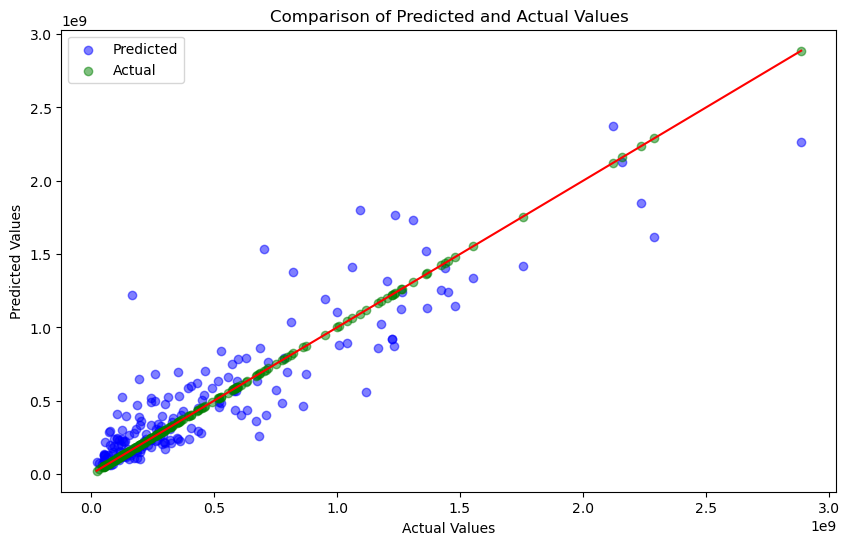

In [24]:
plt.figure(figsize=(10, 6))

# Scatter plot for predicted values (default color)
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted', color='blue')

# Scatter plot for actual values (different color)
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='green')

plt.title('Comparison of Predicted and Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red') # Diagonal line
plt.legend()
plt.show()

### Conclusion
We set out to examine a dataset of the most streamed songs in 2023. We wanted to see if it was possible to predict how popular a song would be based on the features in the dataset. Before starting on the model selection and training, we first had to clean the data since alot of columns had missing or invalid values. 

Given the nature of the problem we wanted to solve, our focus was on regression models. We started out by training five different models, varying in complexity, and ended up finding that the best model was the GradientBoostingRegressor with an initial R2 of 0.80. 
We then used grid search with cross validation to find the best hyperparameters for the model, this further imporved the performance metric of the model to an R2 of 0.81.

This is a pretty good result. We can see that the most important features are the total_playlist and release_date. This makes sense since the more playlists a song is in the more streams it will get. The correlation with release_date is lower but also makes sense since older "classics" are often listened to for a long time, and don't get "old" as many pop songs. The other features are not as important. This might just be because of the size of the dataset, which only includes around 900 songs. If we had a bigger dataset we might have gotten better results and found patterns in relation to the other features.